<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess annotated mouse brain single-cell data from Tabula Muris (Schaum 2018 Nature)

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'06/03/2025'

In [2]:
import os
os.getlogin()

'simonf'

In [56]:
import random
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import platform

In [4]:
import anndata
import scanpy as sc
import scipy as sci
sc.settings.verbosity = 3

In [5]:
import utils

In [6]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [7]:
platform.platform()

'macOS-15.3.1-arm64-arm-64bit'

In [8]:
os.getcwd()

'/Volumes/BD-Dichgans/SF/Git/p06/foxf2-per-celltype'

In [9]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win
main_dir='/Volumes/BD-Dichgans/SF'# Mac

In [10]:
dataset_name = "TabulaMuris2018"
organism = "Mouse"

# Load + format data

## Annotated by authors

Partly adapted from https://github.com/theislab/scib-reproducibility/blob/main/notebooks/data_preprocessing/mouse_brain/01_collect_mouse_brain_studies.ipynb

Using FACS sorted cells, from:  
 -Brain_Myeloid-counts.csv  
 -Brain_Non-Myeloid-counts.csv

Publication: https://www.nature.com/articles/s41586-018-0590-4  
Downloaded from: https://figshare.com/articles/dataset/Single-cell_RNA-seq_data_from_Smart-seq2_sequencing_of_FACS_sorted_cells/5715040

In [11]:
# adata_tamu_myel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Myeloid-counts.csv').T

In [12]:
# adata_tamu_nonmyel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Non-Myeloid-counts.csv').T

In [13]:
# download source differs to the one used by Maren Buettner. I assume Brain_Myeloid-counts equals Brain_Microglia-counts.csv.

In [14]:
adata_tamu_myel = sc.read_csv(os.path.join(main_dir,'P06_vasc_scRNAseq','TabulaMuris2018','FACS','Brain_Microglia-counts.csv')).T

In [15]:
adata_tamu_nonmyel = sc.read_csv(os.path.join(main_dir,'P06_vasc_scRNAseq','TabulaMuris2018','FACS','Brain_Neurons-counts.csv')).T

In [16]:
adata_tamu_myel

AnnData object with n_obs × n_vars = 4762 × 23433

In [17]:
adata_tamu_nonmyel

AnnData object with n_obs × n_vars = 5799 × 23433

Merge brain dataset objects from Tabula Muris. 

In [18]:
adata_tamu = adata_tamu_myel.concatenate(adata_tamu_nonmyel)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [19]:
adata_tamu

AnnData object with n_obs × n_vars = 10561 × 23433
    obs: 'batch'

Convert Tabula Muris dataset into a sparse matrix.

In [20]:
adata_tamu.X = sci.sparse.csr_matrix(adata_tamu.X)

In [21]:
test = [x for x in adata_tamu.obs_names.str.split('-')]

In [22]:
adata_tamu.obs_names = [x[0] for x in test]

Load annotation file.

In [23]:
anno_tamu = pd.read_csv(os.path.join(main_dir,'P06_vasc_scRNAseq','TabulaMuris2018','annotations_FACS.csv'), low_memory=False)
meta_tamu = pd.read_csv(os.path.join(main_dir,'P06_vasc_scRNAseq','TabulaMuris2018','metadata_FACS.csv'))

In [25]:
anno_tamu.shape

(42192, 5)

In [26]:
anno_tamu.columns

Index(['cell', 'tissue', 'cell_ontology_class', 'cell_ontology_term_iri',
       'cell_ontology_id'],
      dtype='object')

In [27]:
red_idx2 = np.isin(adata_tamu.obs.index, anno_tamu.cell)

In [28]:
red_idx2.sum()

7365

In [29]:
adata_tamu = adata_tamu[red_idx2,:]

In [30]:
red_idx = np.isin(anno_tamu.cell,adata_tamu.obs.index)

In [31]:
anno_tamu_red = anno_tamu.loc[red_idx ,:]

In [32]:
anno_tamu_red.index = anno_tamu_red.cell

In [33]:
pd.value_counts(anno_tamu_red.cell_ontology_class)

microglial cell                     4329
oligodendrocyte                     1186
endothelial cell                     625
astrocyte of the cerebral cortex     403
oligodendrocyte precursor cell       202
neuron                               196
unknown                              176
brain pericyte                       132
macrophage                            36
neuronal stem cell                    36
Bergmann glial cell                   30
smooth muscle cell                    14
Name: cell_ontology_class, dtype: int64

In [34]:
adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class
adata_tamu.obs['cell_ontology_class'] = adata_tamu.obs['cell_ontology_class'].astype('category')
adata_tamu.obs['cell_ontology_id'] = anno_tamu_red.cell_ontology_id
adata_tamu.obs['cell_ontology_id'] = adata_tamu.obs['cell_ontology_id'].astype('category')

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12252/2783267983.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class


In [35]:
# adata_tamu.obs['region'] = anno_tamu_red.subtissue
# adata_tamu.obs['region'].loc[pd.isnull(adata_tamu.obs['region'])] ='Unknown'
# adata_tamu.obs['region'] = adata_tamu.obs['region'].astype('category')

In [36]:
# adata_tamu.obs['region'].cat.categories

Rename regions to fit with the other data sets.

In [37]:
# tabula_dict = dict({'Cerebellum' : 'CB', 
#                     'Cortex' : 'CTX', 
#                     'Hippocampus' : 'HC', 
#                     'Striatum' : 'STR'})

In [38]:
# adata_tamu.obs['region'] = adata_tamu.obs['region'].cat.rename_categories(tabula_dict)

In [39]:
# adata_tamu.obs['region'].value_counts()

In [40]:
adata_tamu.obs['study'] = 'Tabula_Muris'

In [41]:
adata_tamu.obs['cell_ontology_class'].cat.categories

Index(['Bergmann glial cell', 'astrocyte of the cerebral cortex',
       'brain pericyte', 'endothelial cell', 'macrophage', 'microglial cell',
       'neuron', 'neuronal stem cell', 'oligodendrocyte',
       'oligodendrocyte precursor cell', 'smooth muscle cell', 'unknown'],
      dtype='object')

Apply own re-ordering of annotation according to cell types of interest:

In [42]:
# # previous from scib:
# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['astrocyte'])

# adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
#                                      ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'astrocyte'

# adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [43]:
# Novel:

In [44]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['Oligos','Endothelial cells','OPCs','Neurons','Pericytes','Microglia/Macrophages','Unknown','Neuronal stem cells','SMCs','Astrocytes'])

In [45]:
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'Pericytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'SMCs'

In [46]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [47]:
adata_tamu.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
Pericytes                 132
Neuronal stem cells        36
SMCs                       14
Name: cell_type, dtype: int64

Remove ERCC tags from genes.

In [48]:
ercc_idx = np.array([tag.startswith('ERCC') for tag in adata_tamu.var_names])

In [49]:
adata_tamu = adata_tamu[:, np.invert(ercc_idx)].copy()

In [50]:
adata=adata_tamu

In [51]:
del adata_tamu

# QC

Not required because already annotated

normalizing counts per cell
    finished (0:00:00)


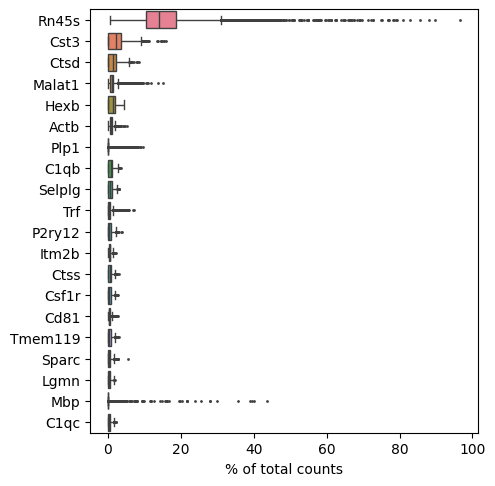

In [52]:
# genes with highest fraction of counts per cell
sc.pl.highest_expr_genes(adata, n_top=20, )

# Normalisation, logarithmization

Check if data is normalized:

In [53]:
adata.layers

Layers with keys: 

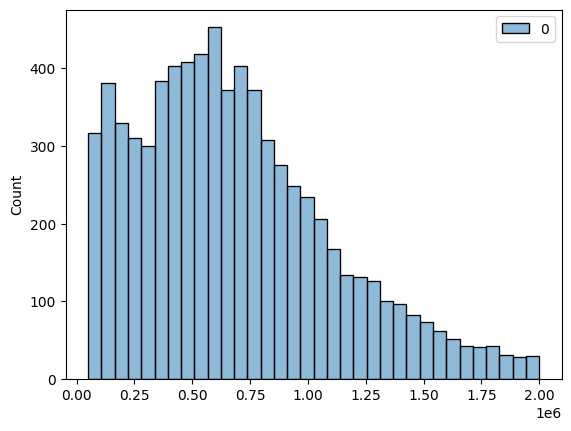

In [54]:
sb.histplot(adata.X.sum(1), kde=False)
plt.show()

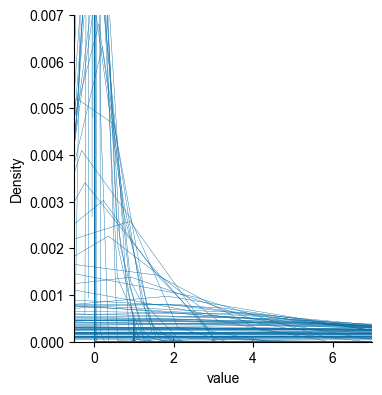

In [57]:
# show expression of 100 random genes (across all spots)
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
sns.set_theme(style='white')
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12252/3567377032.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


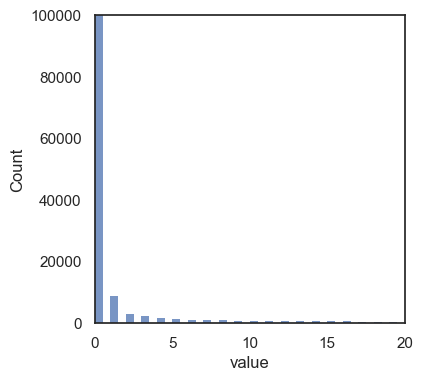

In [58]:
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [59]:
exp

0     1    2    3    4    5    6     7    8    9   ...   90   91   92  \
0     0.0  32.0  0.0  0.0  0.0  0.0  0.0  12.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...   ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
7360  0.0   0.0  3.0  0.0  0.0  0.0  0.0   0.0  8.0  0.0  ...  0.0  0.0  0.0   
7361  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
7362  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
7363  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   
7364  0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0  0.0  0.0   

           93   94   95   96    97   98    99  
0         0.0  0.0  0.0  0.0   0.0  0.0   0.0  
1         0.0  0.0  0.0  0.0   0.0  0.0   0.0  
2         0.0  0.0  0.0  0.0   0.0  0.0  23.0  
3         0.0  0.0  0.0  0.0   0.0  0.0   5.0  
4         0.0  0.0  0.0  0.0   0.0  0.0   0.0  
...       ...  ...  ...  ...   ...  ...   ...  
7360      0.0  0.0  0.0  0.0  64.0  3.0   0.0  
7361  11730.0  0.0  0.0  0.0   0.0  0.0   0.0  
7362      0.0  0.0  0.0  0.0   0.0  0.0   0.0  
7363      0.0  0.0  0.0  0.0   0.0  0.0   0.0  
7364      0.0  0.0  0.0  0.0   0.0  0.0   0.0  

[7365 rows x 100 columns]

In [60]:
adata.layers["counts"] = adata.X.copy()

In [61]:
sc.pp.normalize_total(adata, inplace=True)

normalizing counts per cell
    finished (0:00:00)


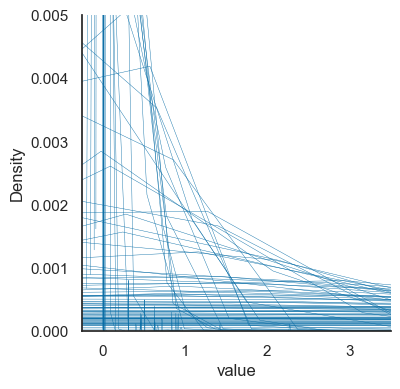

In [62]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12252/1040332646.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))


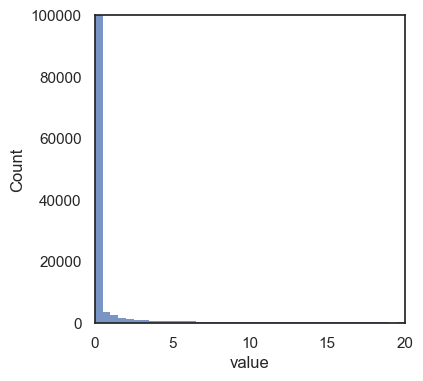

In [63]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [64]:
sc.pp.log1p(adata) # X = log(X + 1)

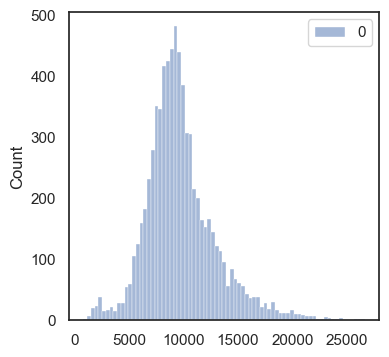

In [65]:
sb.histplot(adata.X.sum(1), kde=False)
plt.show()

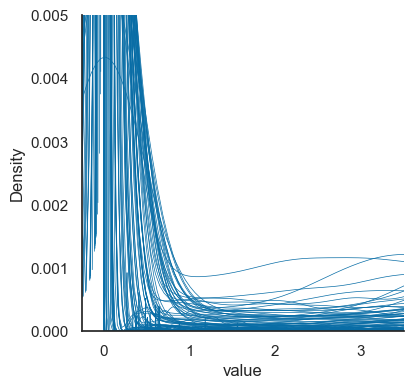

In [66]:
# show expression of 100 random genes (across all spots)
sns.set_theme(style='white')
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12252/3243830788.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));


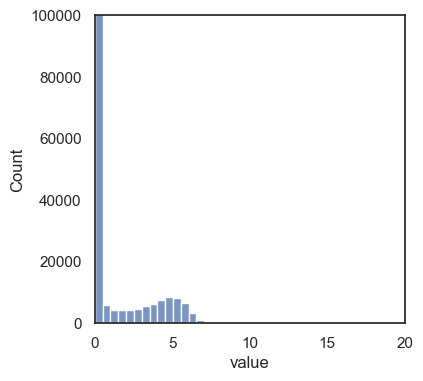

In [67]:
sns.set_theme(style='white')
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)));
pl.set(xlim=(0, 20),ylim=(0,1e5));

In [68]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


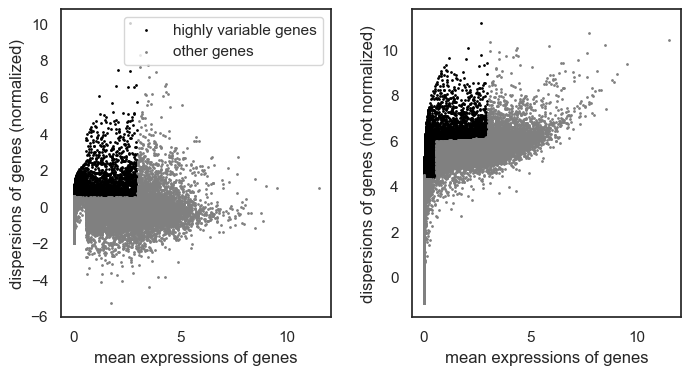

In [69]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [70]:
adata

AnnData object with n_obs × n_vars = 7365 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'normalized'

In [71]:
adata.layers

Layers with keys: counts, normalized

# Dim Reduction

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


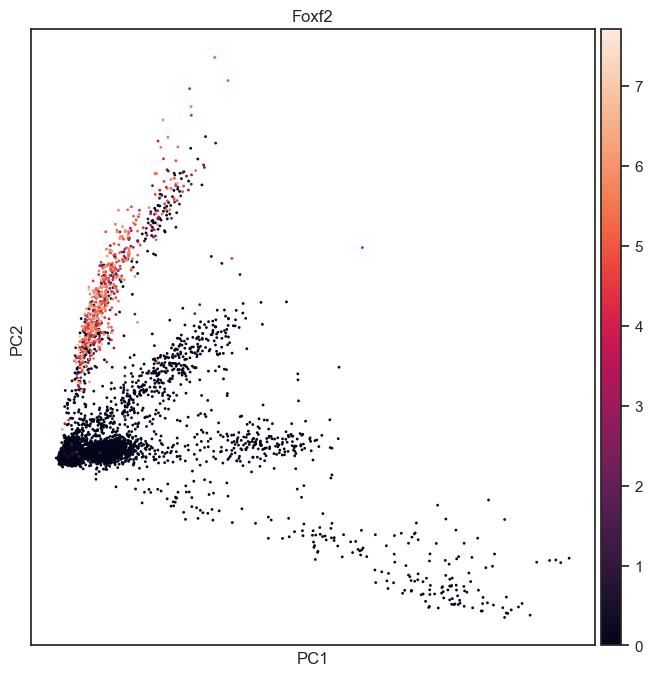

In [72]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca(adata, color='Foxf2')

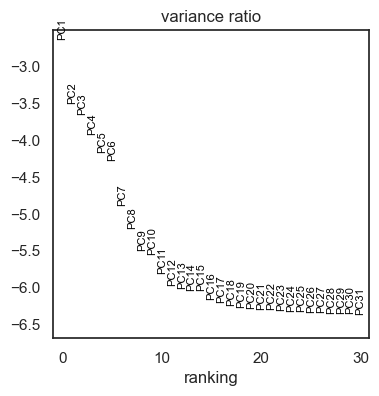

In [73]:
sc.pl.pca_variance_ratio(adata, log=True)

In [74]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [75]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [76]:
list(adata.obs.columns)

['batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type']

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


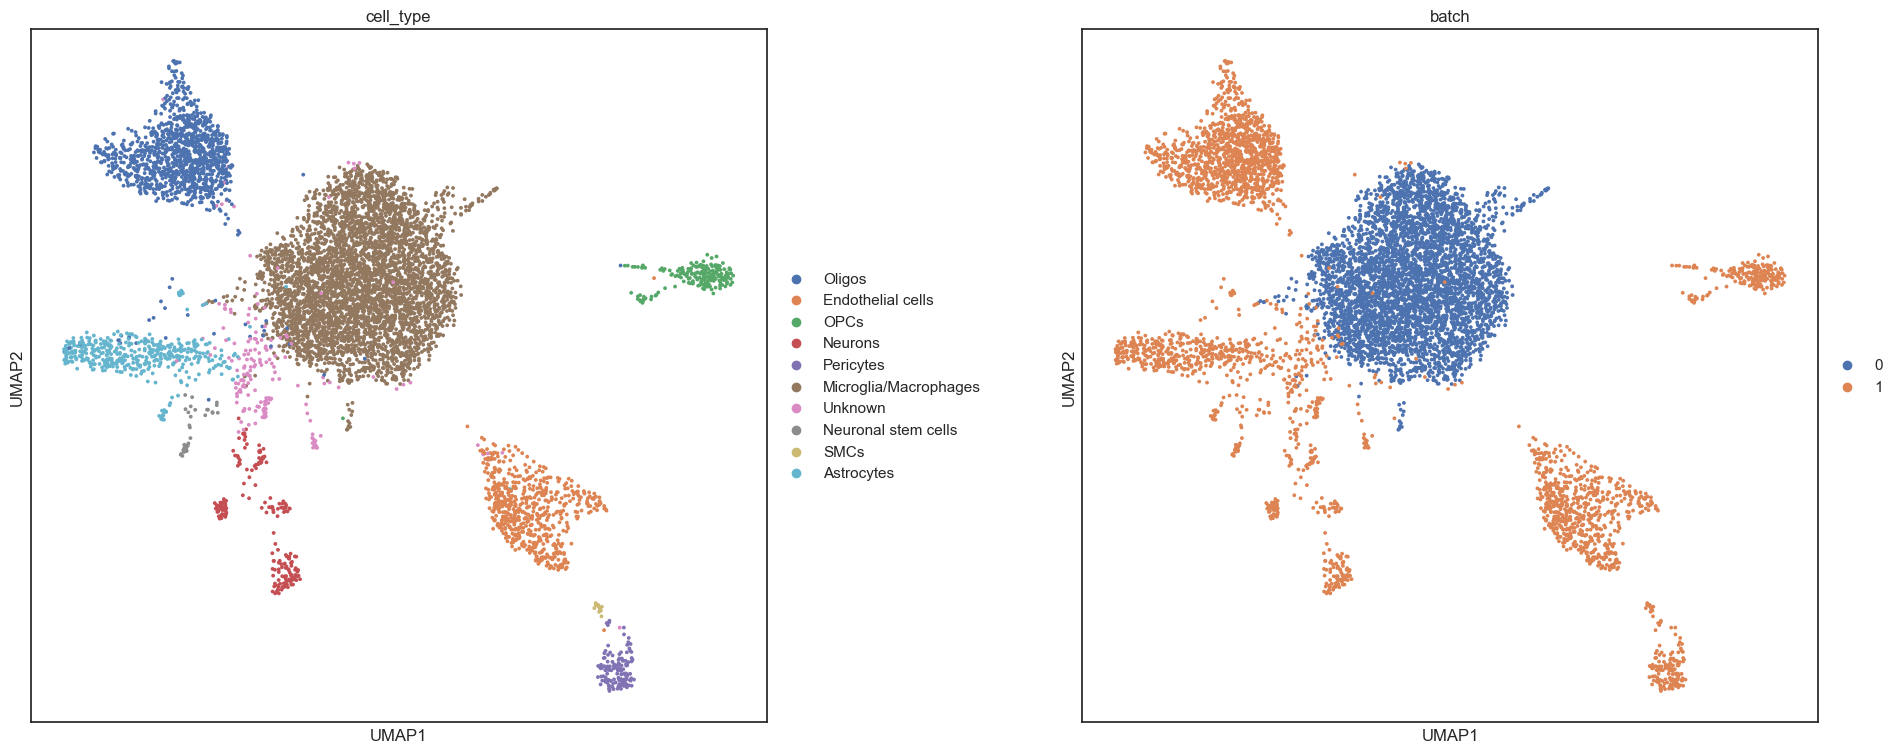

In [77]:
with rc_context({'figure.figsize': (9, 9)}):
    sc.pl.umap(adata, color=['cell_type', 'batch'], wspace=0.3, size=30)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


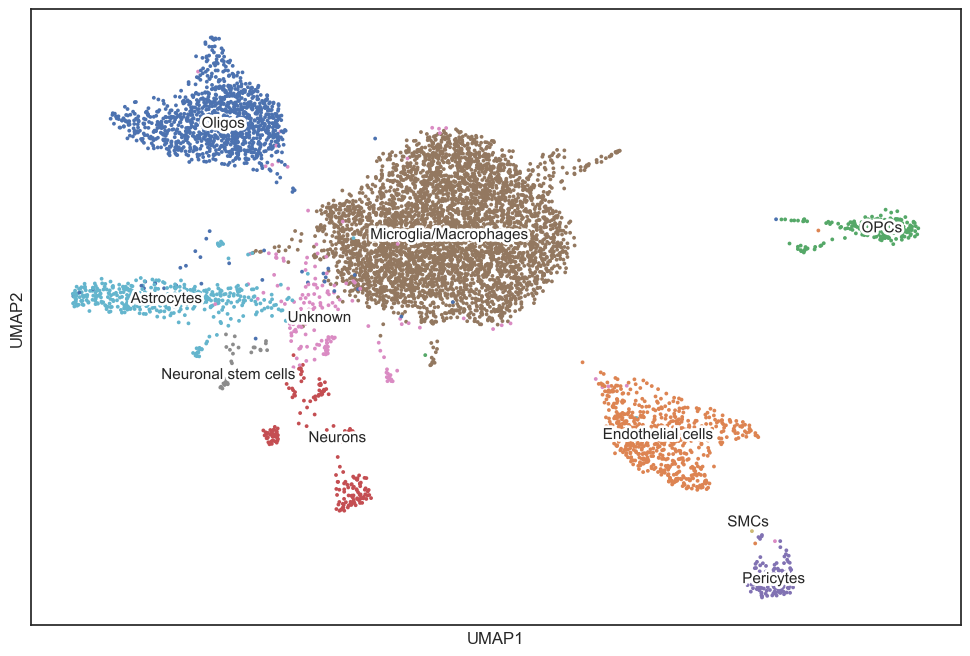

In [78]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=4, legend_fontsize=11, size=30)

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


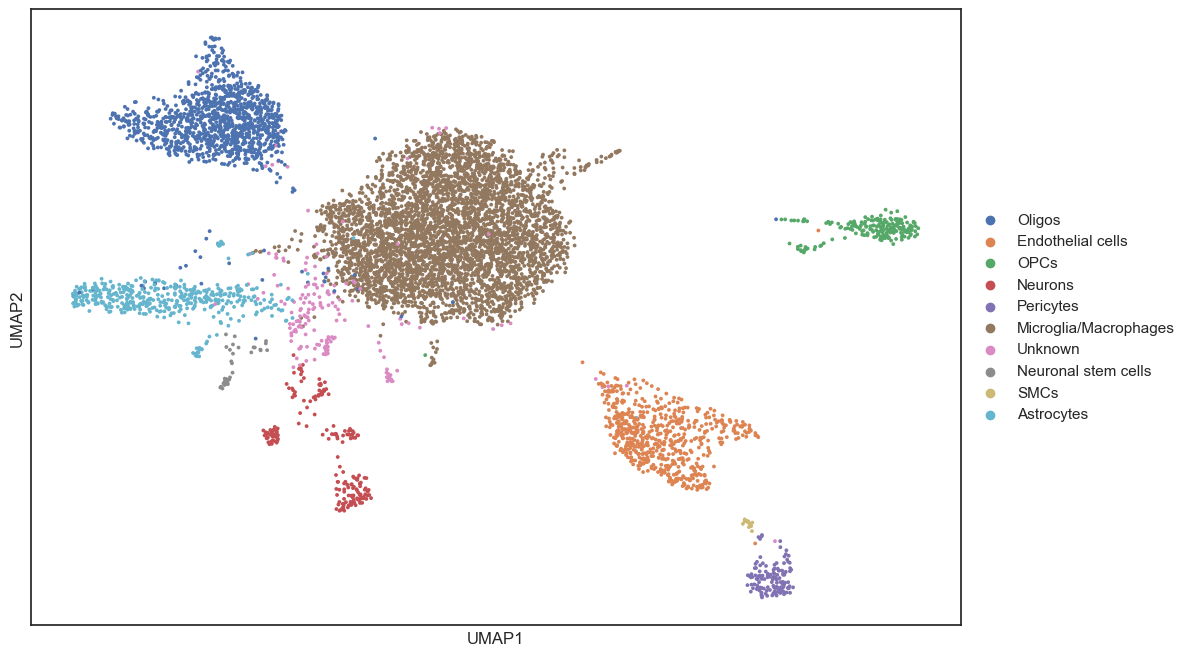

In [79]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], title='', legend_fontweight='normal', legend_fontoutline=4, legend_fontsize=11, size=30)

Note: SMC cluster is very small

In [80]:
adata.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
Pericytes                 132
Neuronal stem cells        36
SMCs                       14
Name: cell_type, dtype: int64

# Cell annotation

Verify annotation from authors

Manual marker gene selection

|Vascular     |EC         |Pericytes|SMCs   |Fibroblasts|Oligos|OPCs         |Ependymal|Neurons    |immature/migrating Neurons|Astrocytes|Microglia|Immune (broad/hematopoetic)|Macrophages     |Macrophages/Microglia|Monocytes|Mononcytes/B-cells|Granulocytes|B-cells|T/NK cells|
|---          |---        |---      |---    |---        |---   |---          |---      |---        |---   |---       |---      |---                        |---             |---|---|---|---|---|---|
|PDGFRA =CD140A|CLDN5      |VTN      |ACTA2  |DCN        |MBP   |CSPG4 =NG2    |PIFO     |RBFOX3 =NEUN|DCX   |AQP4      |AIF1     |PTPRC =CD45                 |CD14            |TREM2|CCR2|CD74|CD16/32|CD19|CD4|
|MCAM =CD146   |PECAM1 =CD31|PDGFRB   |MYOCD  |COL6A1     |ENPP2 |PDGFRA =CD140A|FOXJ1    |TUBB3      ||          |         |                           |ITGB2 =CD18 =CD11B||||ITGB2 =CD18 =CD11B||CD8A|
|FOXF2        |           |         |       |COL3A1     |      |             |DYNLRB2  |           ||          |         |                           |CD86            ||||CD15||CD8B|
|             |           |         |       |           |      |             |MEIG1    |           ||          |         |                           |ADGRE1 =F4/80    ||||||IL2RB|
||||||||||||||||||||IFNG|

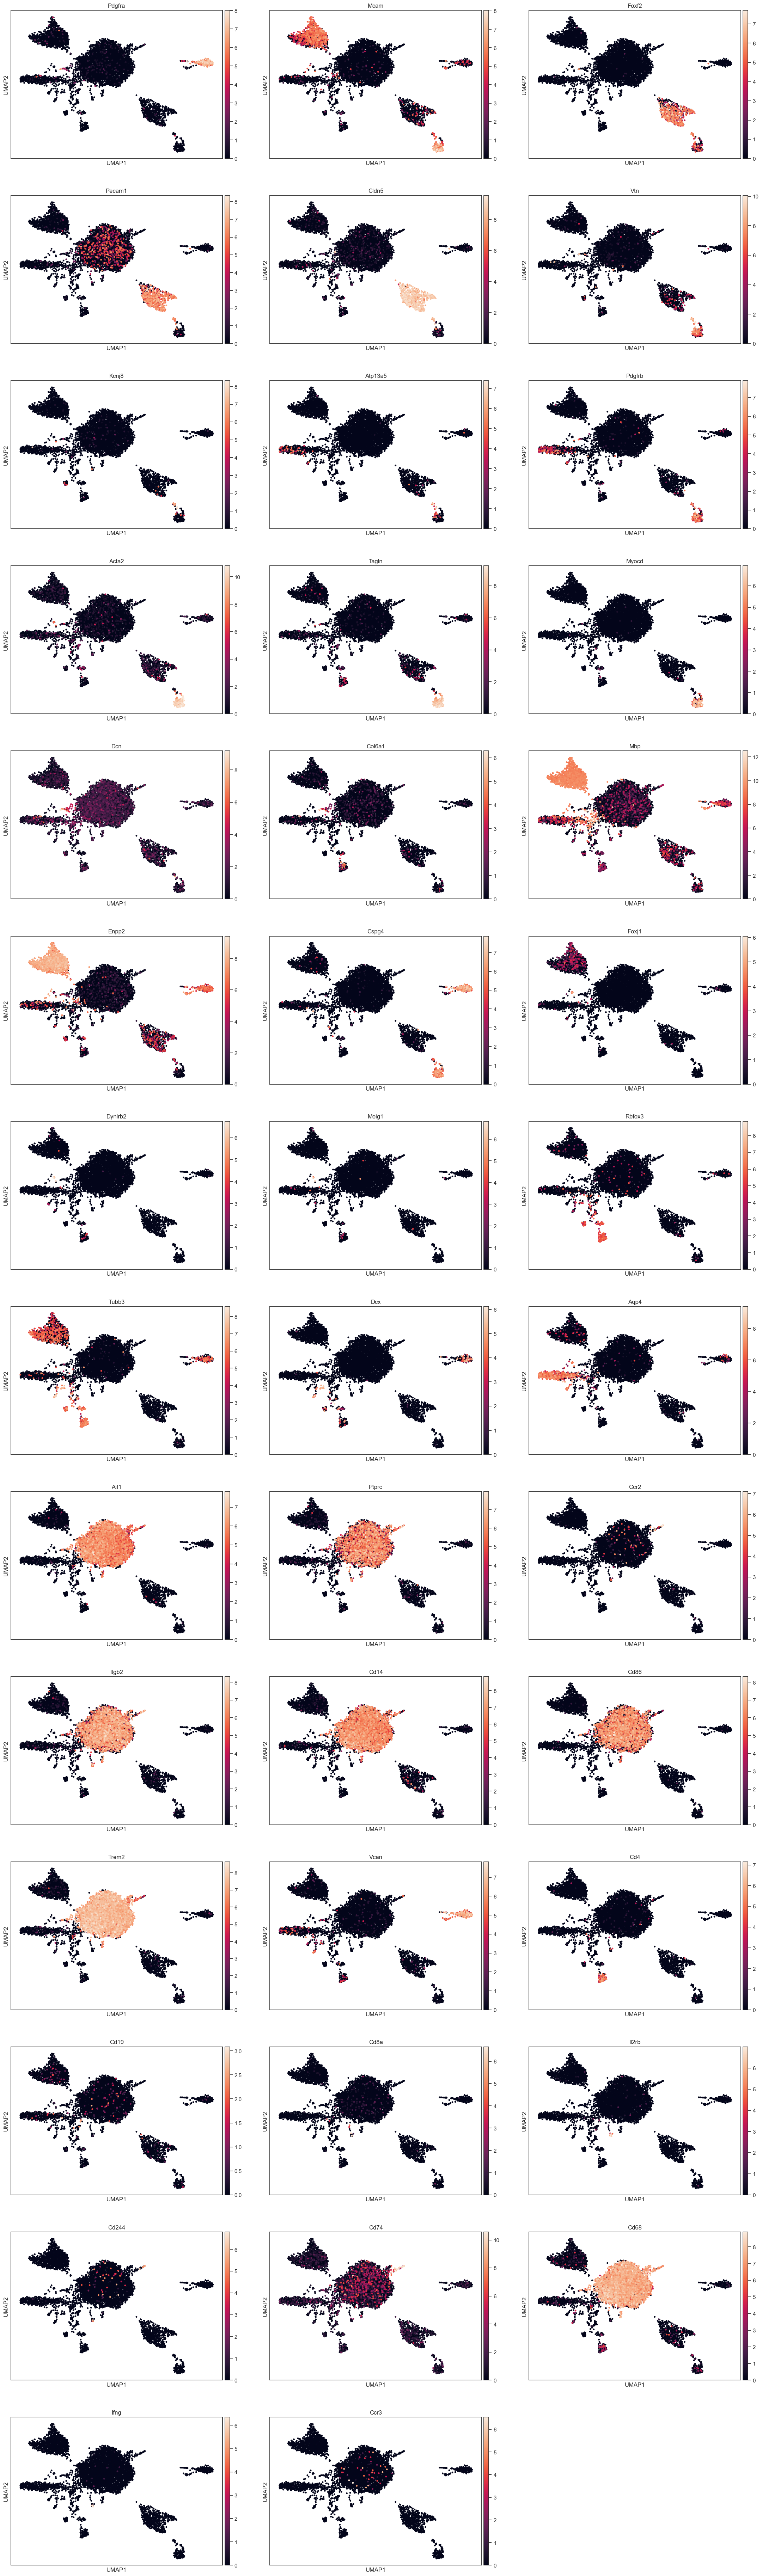

In [81]:
# plot marker genes
plt.rcParams['figure.figsize'] = [8, 6] # set plot sizes
marker_genes = ["Pdgfra", "Mcam","Foxf2", "Pecam1", "Cldn5","Vtn","Kcnj8","Atp13a5","Pdgfrb","Acta2","Tagln","Myocd","Dcn", "Col6a1", "Mbp","Enpp2","Cspg4","Pifo","Foxj1","Dynlrb2","Meig1","Rbfox3","Tubb3","Dcx","Aqp4", "Aif1", "Ptprc", "Ccr2","Adgre1","Itgb2","Cd14","Cd86","Trem2","Vcan","Cd4","Cd19", "Cd8a","Il2rb","Cd244", "Cd74","Cd68","Ifng","Ptgdr2","Ccr3"]
marker_genes=[x for x in marker_genes if x in list(adata.var_names)] # remove those not in adata.var_names
sc.pl.umap(adata, ncols=3, color=marker_genes, size=50)

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


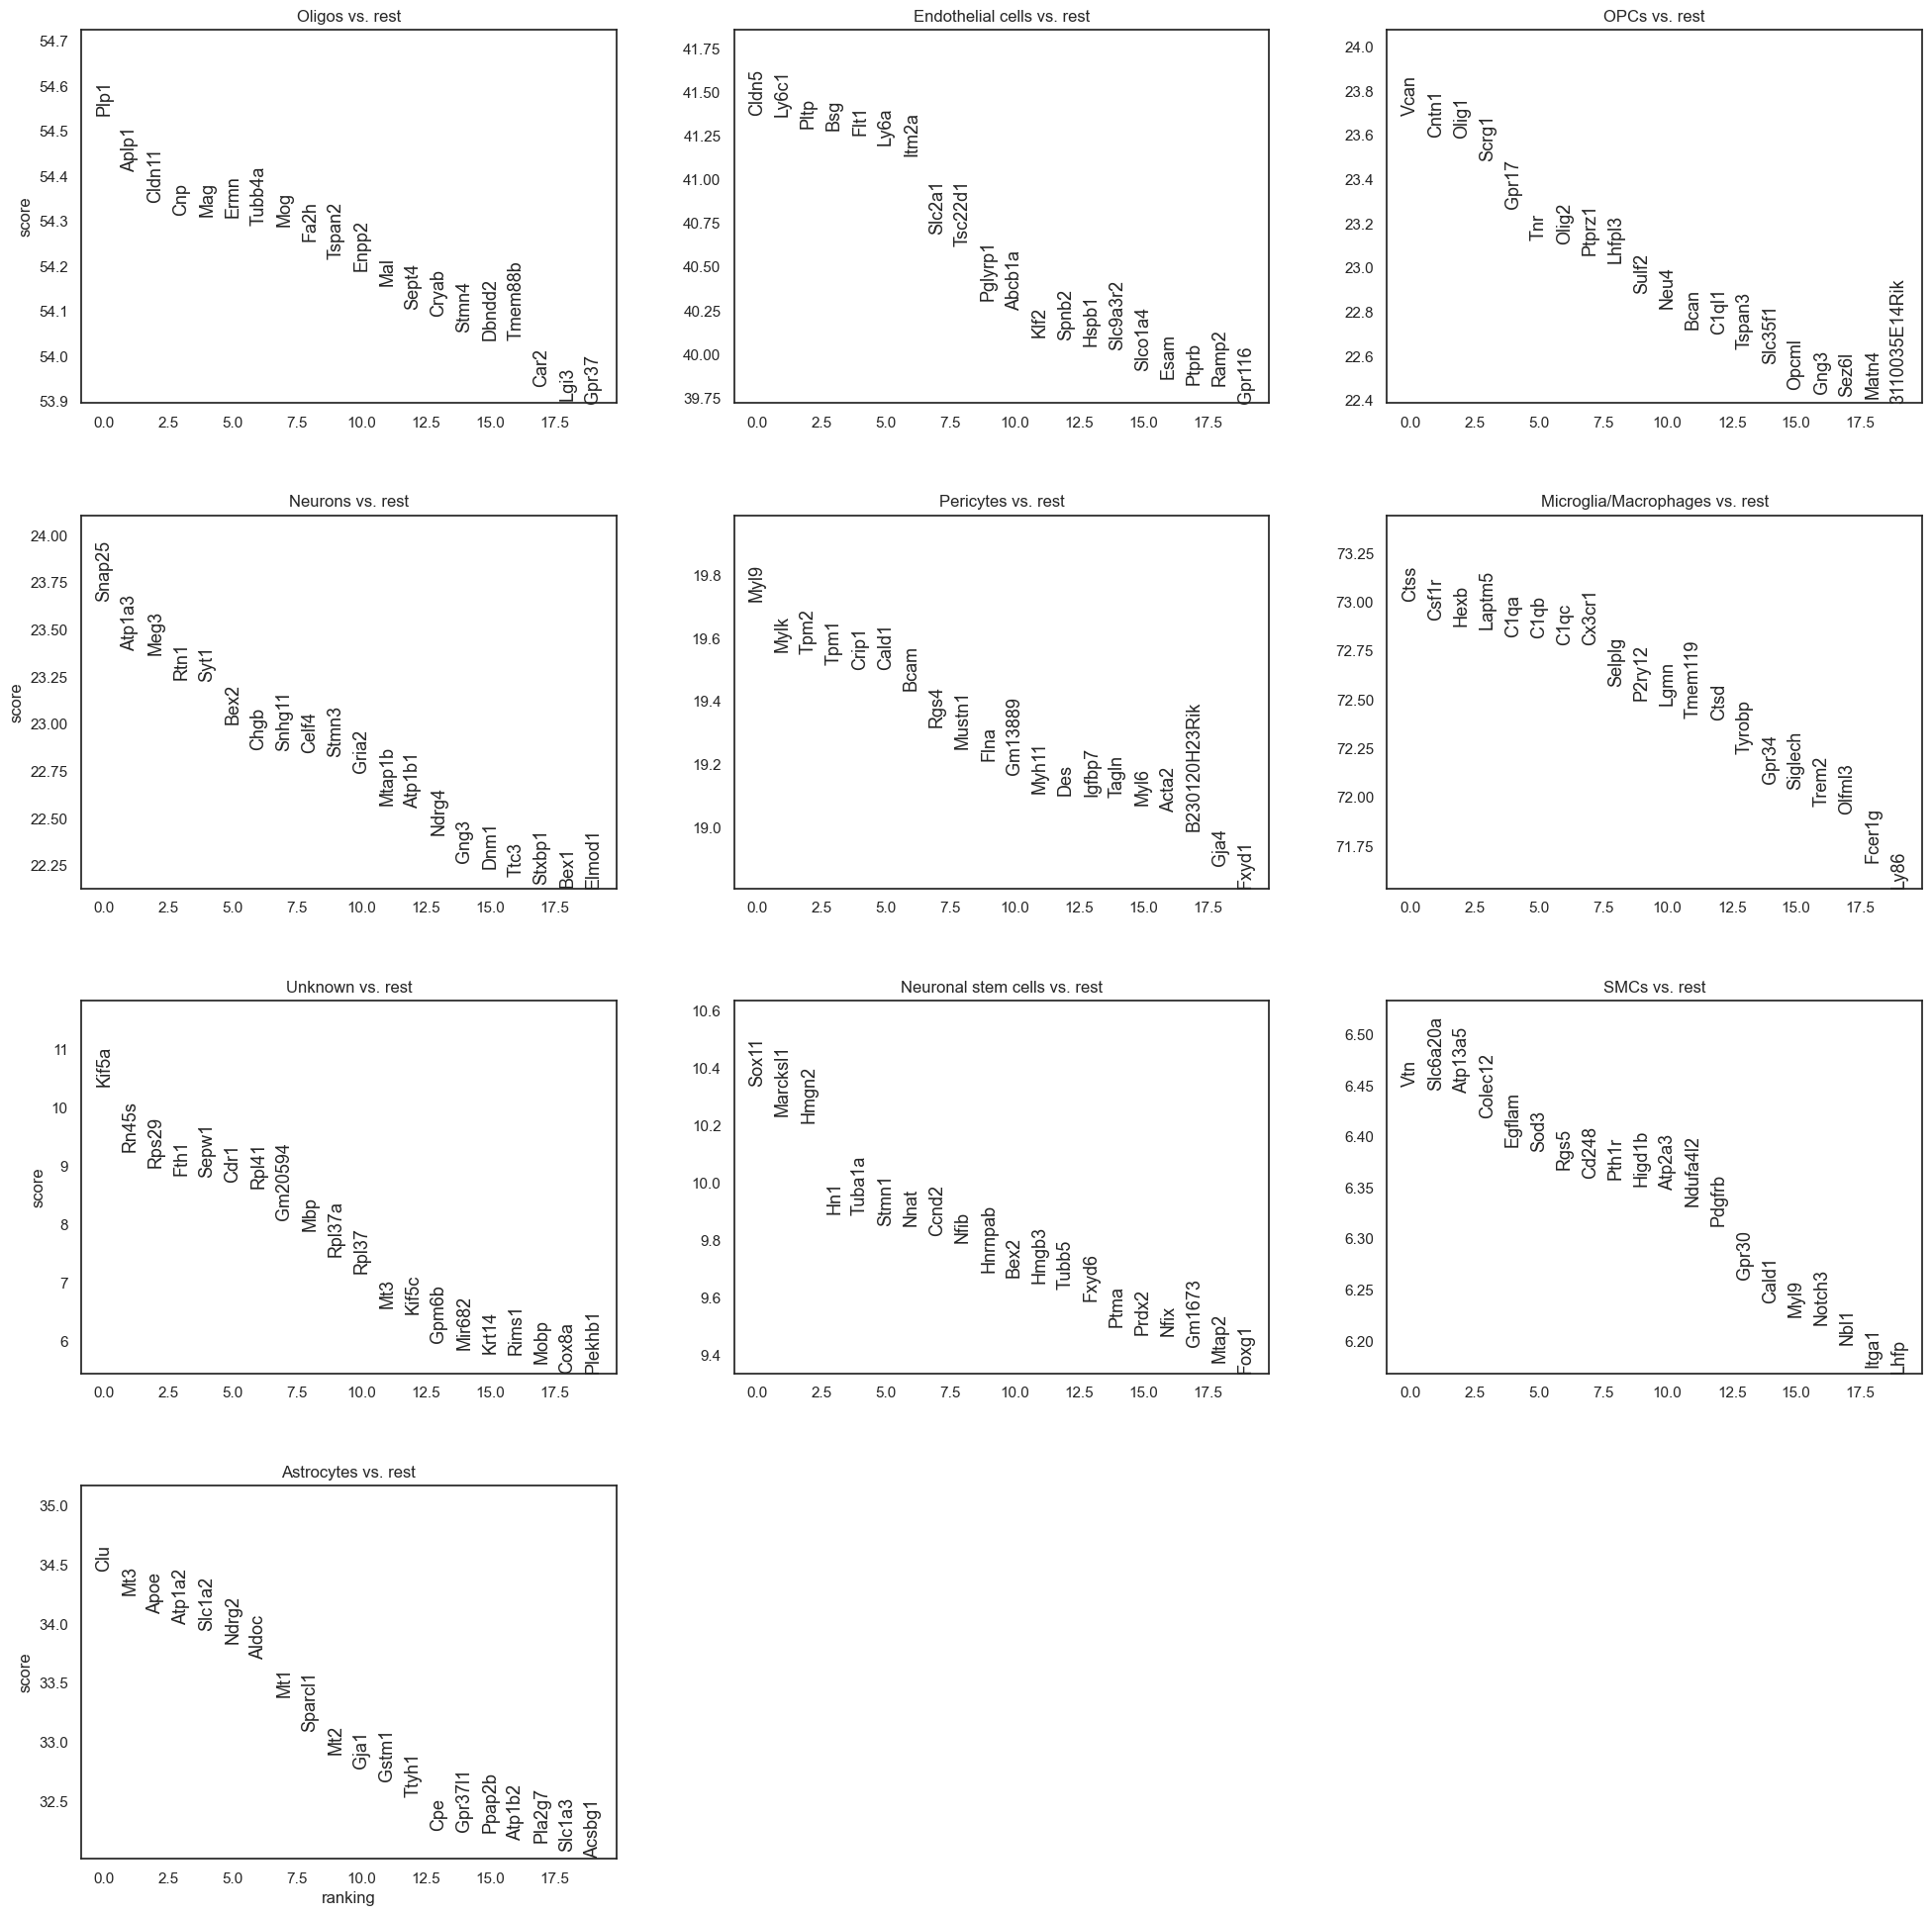

In [82]:
# Run DE test for annotation (Wilcoxon)
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon', key_added='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, ncols=3, fontsize=13, key='wilcoxon')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


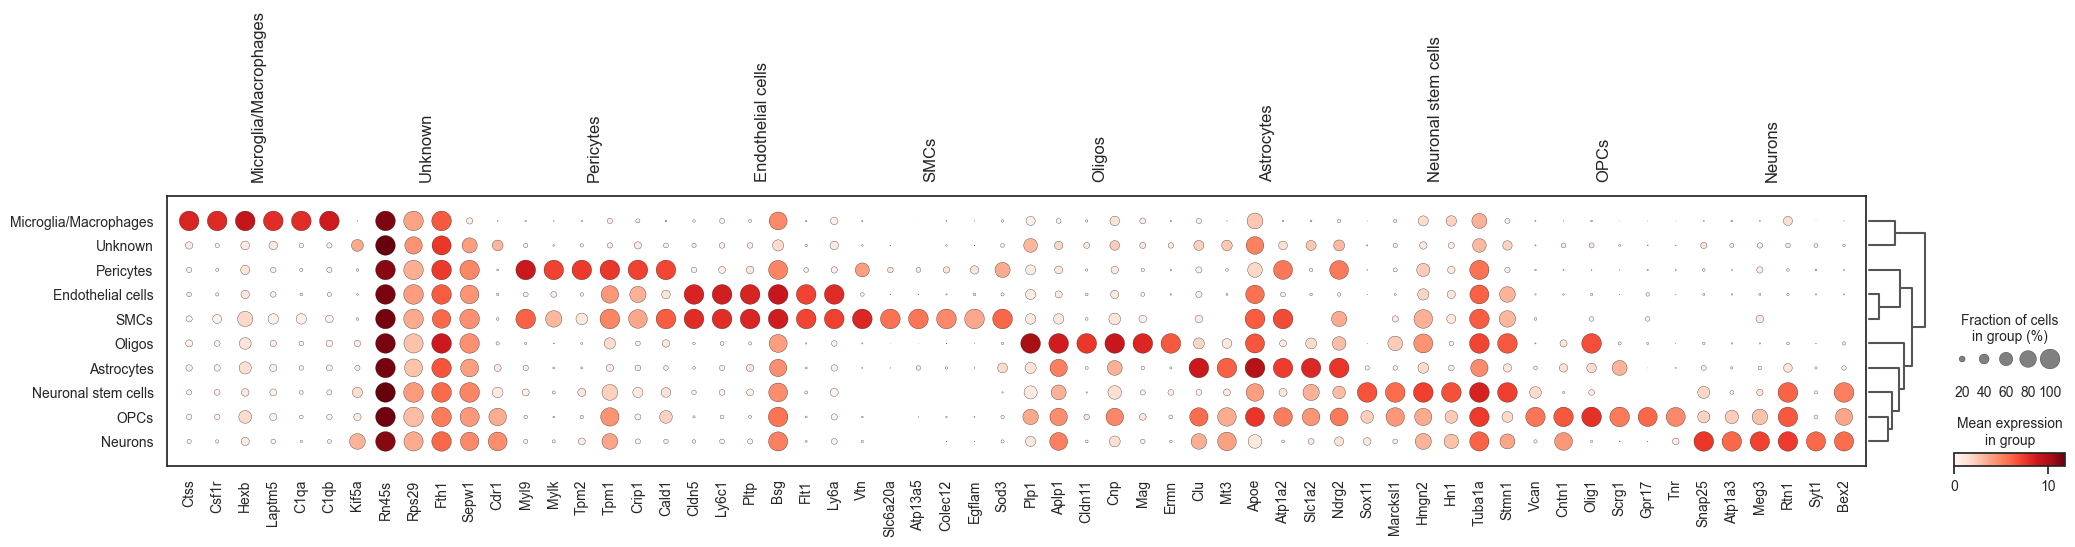

In [83]:
# Dotplot
sc.tl.dendrogram(adata, groupby="cell_type")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, key="wilcoxon", groupby="cell_type");

Own note: The clusters SMCs and Pericytes seem to be wrongly switched. The pericyte markers Vtn, Atp13a5, Pdgfrb are among top SMC hits. Conversely, SMC marker genes are constituting the top hits from the pericyte cluster. Therefore, switch annotations:


In [84]:
adata_tamu = adata
adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'Astrocytes'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte'])] =  'Oligos'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['endothelial cell'])] =  'Endothelial cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['oligodendrocyte precursor cell'])] =  'OPCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuron'])] =  'Neurons'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['brain pericyte'])] =  'SMCs'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['macrophage','microglial cell'])] =  'Microglia/Macrophages'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['unknown'])] =  'Unknown'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['neuronal stem cell'])] =  'Neuronal stem cells'

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['smooth muscle cell'])] =  'Pericytes'
adata = adata_tamu
del adata_tamu

In [85]:
adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

In [86]:
adata.obs['cell_type'].value_counts()

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
SMCs                      132
Neuronal stem cells        36
Pericytes                  14
Name: cell_type, dtype: int64

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


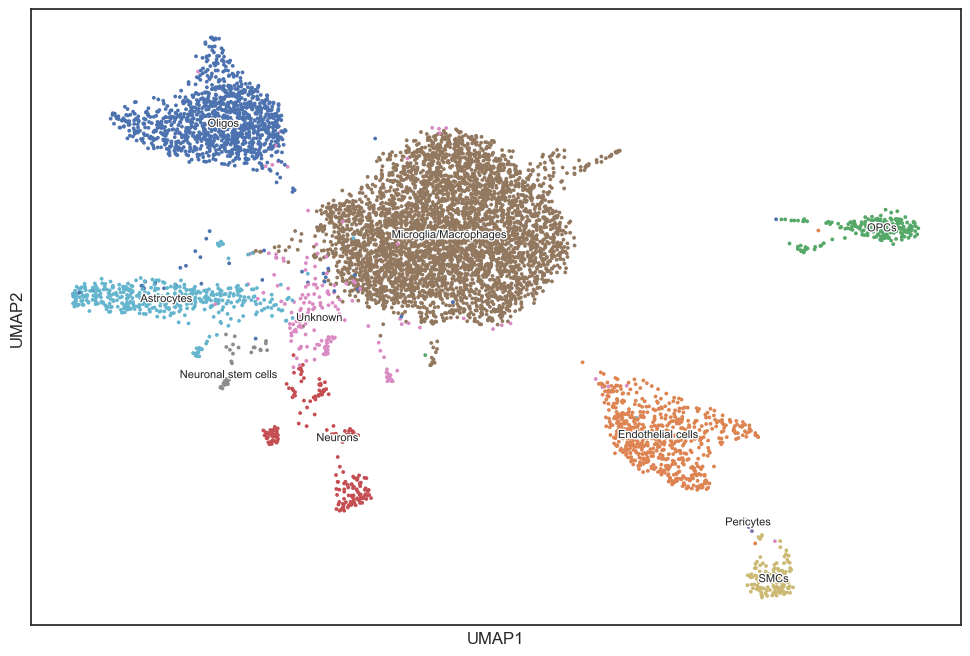

In [87]:
plt.rcParams['figure.figsize'] = [12, 8] # set plot sizes
sc.pl.umap(adata, color=['cell_type'], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=8, size=30)

In [88]:
# exclude clusters with <50 cells
cluster_counts = adata.obs['cell_type'].value_counts()
cluster_counts

Microglia/Macrophages    4365
Oligos                   1186
Endothelial cells         625
Astrocytes                433
OPCs                      202
Neurons                   196
Unknown                   176
SMCs                      132
Neuronal stem cells        36
Pericytes                  14
Name: cell_type, dtype: int64

In [89]:
adata = adata[adata.obs['cell_type'].isin(cluster_counts[cluster_counts>49].index)]

In [90]:
adata.obs['clusters'] = adata.obs['cell_type']

/var/folders/8v/lcvg2wdd2ll8p7lhpn57pz8c0000gn/T/ipykernel_12252/136208837.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['clusters'] = adata.obs['cell_type']


# Focus on: Foxf2

In [91]:
gene="Foxf2"

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


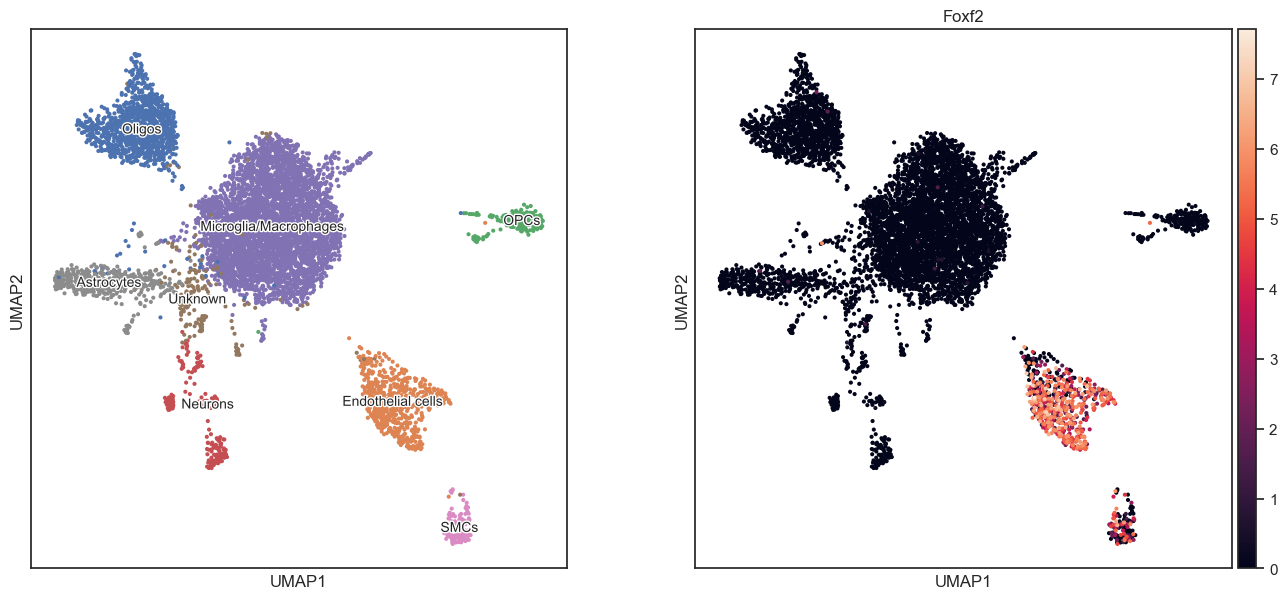

In [92]:
with rc_context({'figure.figsize': (7,7)}):
    sc.pl.umap(adata, color=['clusters',gene], legend_loc='on data', title='', legend_fontweight='normal', legend_fontoutline=2, legend_fontsize=10, size=35, layer="normalized")

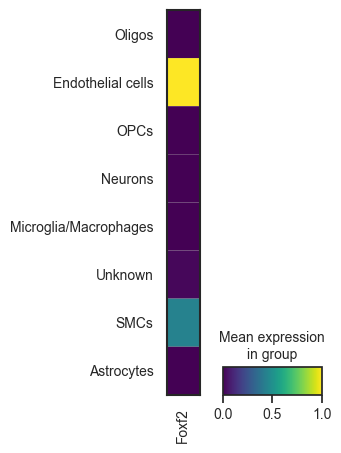

In [93]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


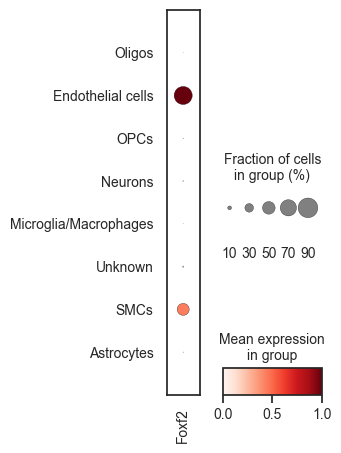

In [94]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [95]:
utils.summarize_gene_expression(adata = adata, gene = gene, groupby = "clusters", 
                          study_name = dataset_name, organism = organism,
                          export = True, output_dir = os.path.join(main_dir, "P06_Foxf2_per_celltype", "Foxf2_summarized")
                         )

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Foxf2_summarized/20250306_Foxf2_TabulaMuris2018_layernormalized.csv


mean_expression  fraction_of_cells   gene  \
clusters                                                           
Oligos                        0.000606           0.001686  Foxf2   
Endothelial cells             1.000000           0.806400  Foxf2   
OPCs                          0.000000           0.004950  Foxf2   
Neurons                       0.000495           0.010204  Foxf2   
Microglia/Macrophages         0.000184           0.002291  Foxf2   
Unknown                       0.019235           0.022727  Foxf2   
SMCs                          0.438674           0.469697  Foxf2   
Astrocytes                    0.001862           0.004619  Foxf2   

                                source organism  cell_number  
clusters                                                      
Oligos                 TabulaMuris2018    Mouse         1186  
Endothelial cells      TabulaMuris2018    Mouse          625  
OPCs                   TabulaMuris2018    Mouse          202  
Neurons                TabulaMuris2018    Mouse          196  
Microglia/Macrophages  TabulaMuris2018    Mouse         4365  
Unknown                TabulaMuris2018    Mouse          176  
SMCs                   TabulaMuris2018    Mouse          132  
Astrocytes             TabulaMuris2018    Mouse          433

# Focus on: Other genes

In [96]:
target_genes = ["Foxo1", "Tek", "Nos3", "Htra1", "Egfl8", "Flt1", "Kdr", "Ptprb", "Nrp1", "Nrp2", "Efnb2", "Itgb1", "Itga6", "Angpt2", "Cdh5", "Cldn5", "Ocln", "Ctnnb1"]

In [97]:
other_genes_results = {
    gene: utils.summarize_gene_expression(adata, gene, groupby = "clusters", study_name = dataset_name, organism = organism, 
                                    output_dir=os.path.join(main_dir, "P06_Foxf2_per_celltype", "Other_genes_summarized"), export=True
                                   ) for gene in target_genes
}

Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Foxo1_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Tek_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Nos3_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Htra1_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Egfl8_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Flt1_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summarized/20250306_Kdr_TabulaMuris2018_layernormalized.csv
Exported to /Volumes/BD-Dichgans/SF/P06_Foxf2_per_celltype/Other_genes_summ

In [98]:
# some plots

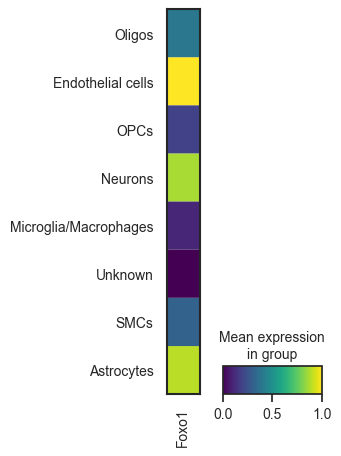

In [99]:
sc.pl.matrixplot(adata, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


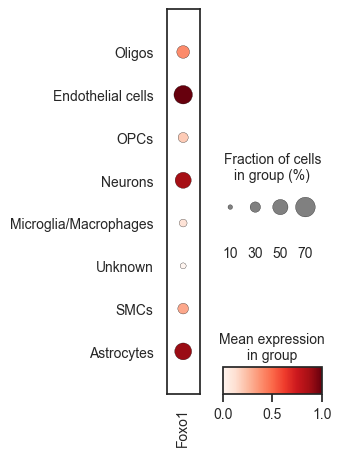

In [100]:
sc.pl.dotplot(adata, [target_genes[0]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

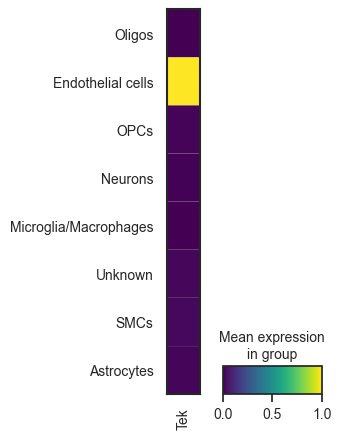

In [101]:
sc.pl.matrixplot(adata, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

/Users/simonf/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


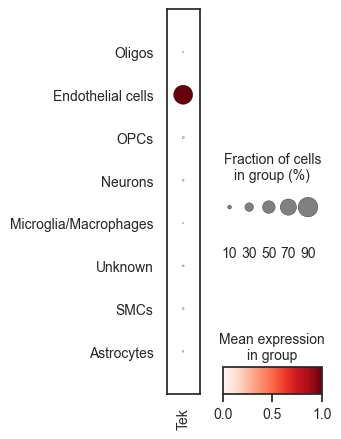

In [102]:
sc.pl.dotplot(adata, [target_genes[1]], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [95]:
import magic
import scprep

In [97]:
sns.set_theme(style='white')

## ECs

In [98]:
gg = ["Foxf2","Foxo1","Nos3"]

In [104]:
adata_EC = adata[adata.obs.cell_type == "Endothelial cells"]

In [105]:
adata_EC

View of AnnData object with n_obs × n_vars = 625 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [106]:
adata_EC.layers

LayersView with keys: counts, normalized

In [107]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [108]:
cutoff_var = None

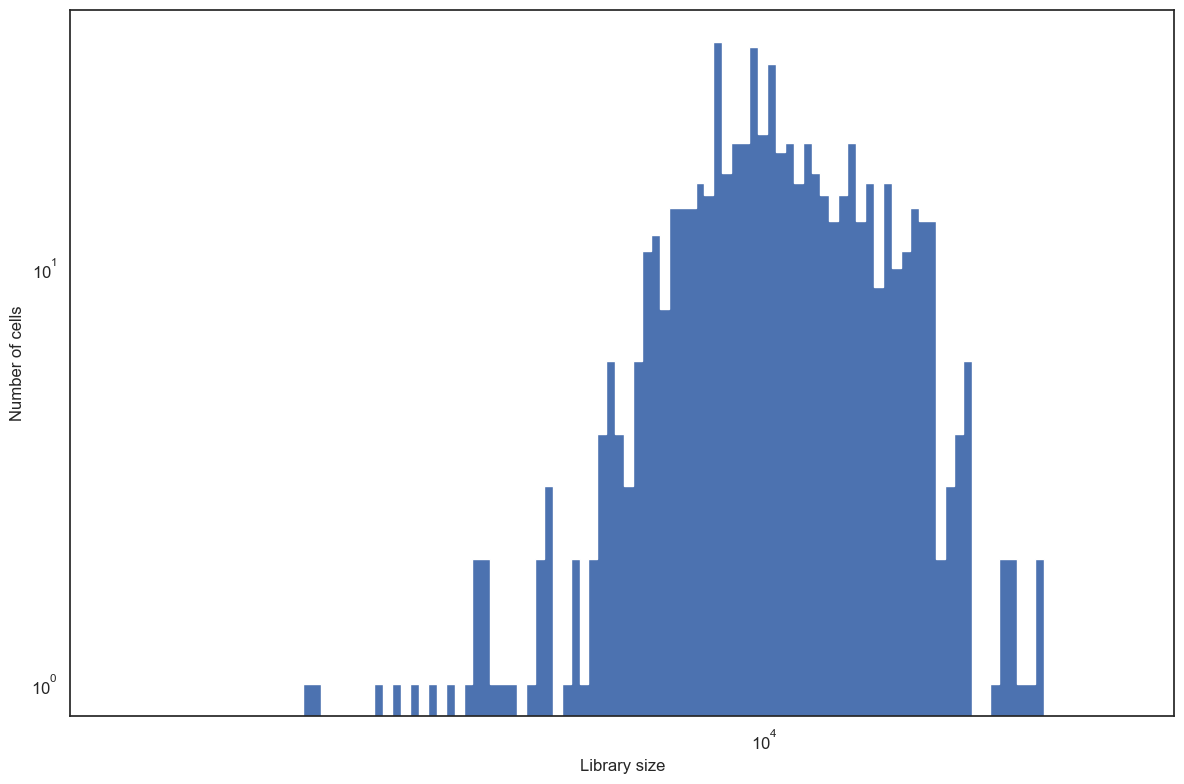

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [109]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [111]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [112]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [113]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [114]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 625 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 2.11 seconds.
  Calculating imputation...
Calculated MAGIC in 2.19 seconds.
CPU times: total: 4.8 s
Wall time: 2.19 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [115]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.9600462881967134

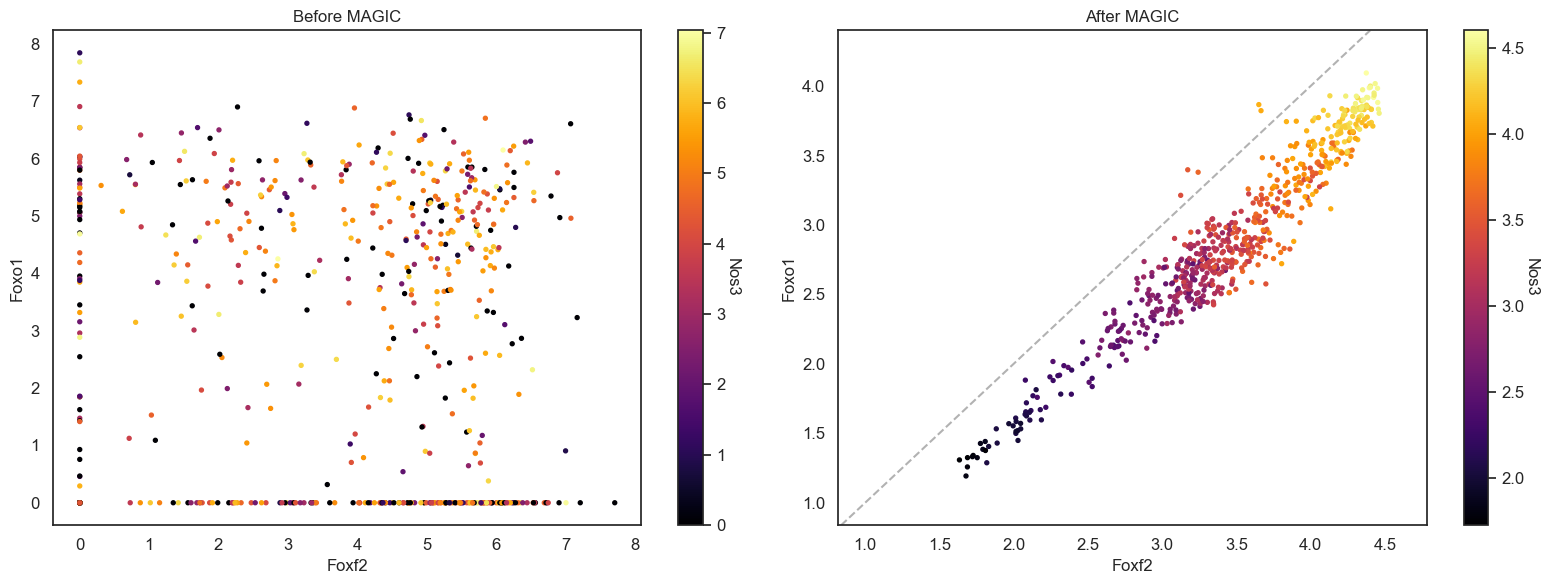

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [126]:
# no pericytes in dataset

## SMCs

In [127]:
gg = ["Foxf2","Foxo1","Nos3"]

In [128]:
adata_EC = adata[adata.obs.cell_type == "SMCs"]

In [129]:
adata_EC

View of AnnData object with n_obs × n_vars = 132 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [130]:
adata_EC.layers

LayersView with keys: counts, normalized

In [131]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [132]:
cutoff_var = None

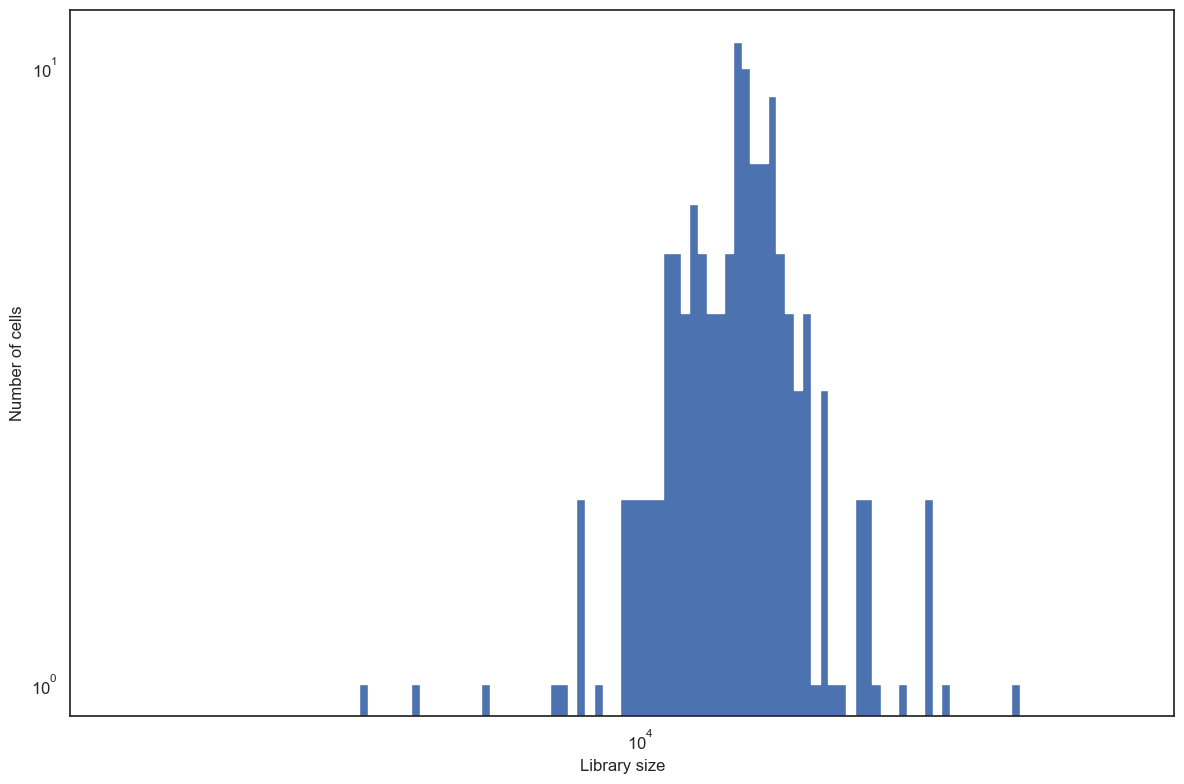

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [133]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [134]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [135]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [136]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [137]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 132 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.95 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.96 seconds.
  Calculating imputation...
Calculated MAGIC in 1.03 seconds.
CPU times: total: 2.36 s
Wall time: 1.03 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [138]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.17322498013054155

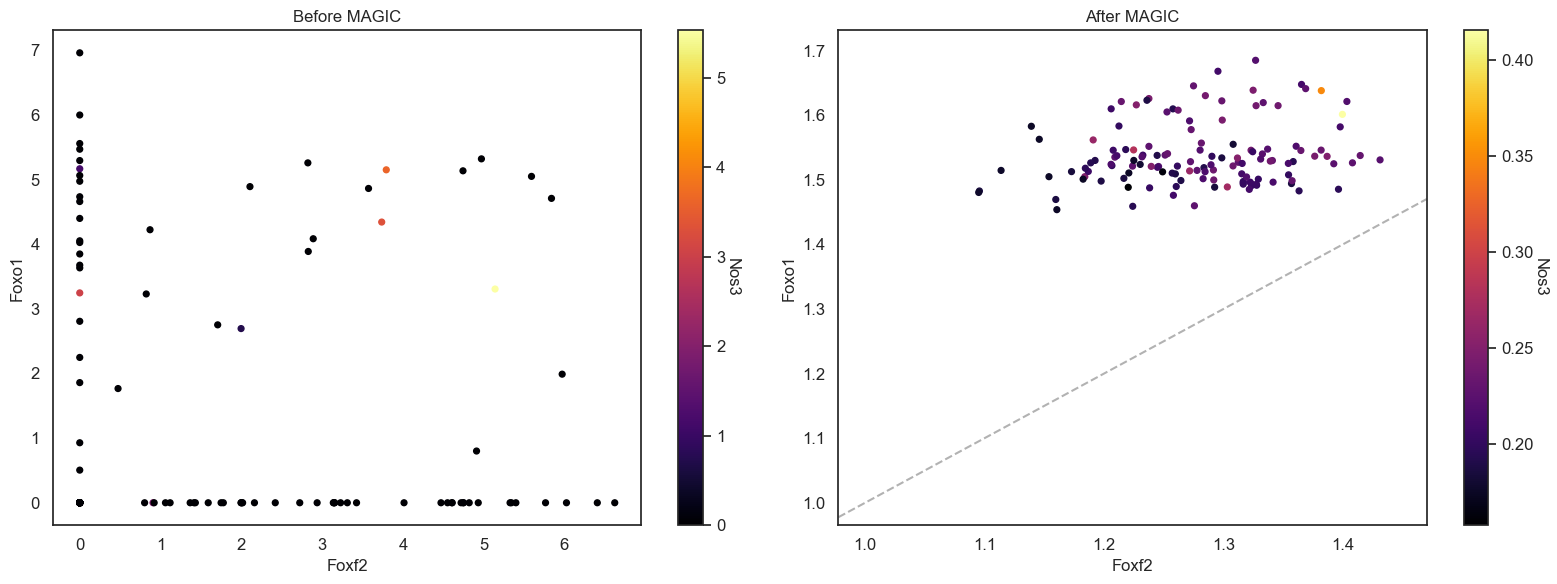

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'Foxf2'].X.todense(), y=adata_EC[:,'Foxo1'].X.todense(), c=adata_EC[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [143]:
adata

View of AnnData object with n_obs × n_vars = 7315 × 23341
    obs: 'batch', 'cell_ontology_class', 'cell_ontology_id', 'study', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'cell_type_colors', 'batch_colors', 'wilcoxon', 'dendrogram_cell_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities'

In [145]:
#matrix = pd.DataFrame(adata.X) # not compatible with sparse 
matrix = adata.X
#matrix.columns = ad_merged.var.index.tolist()

In [146]:
cutoff_var = 700

C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\scprep\plot\histogram.py:180: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.axvline(cutoff, color="red")


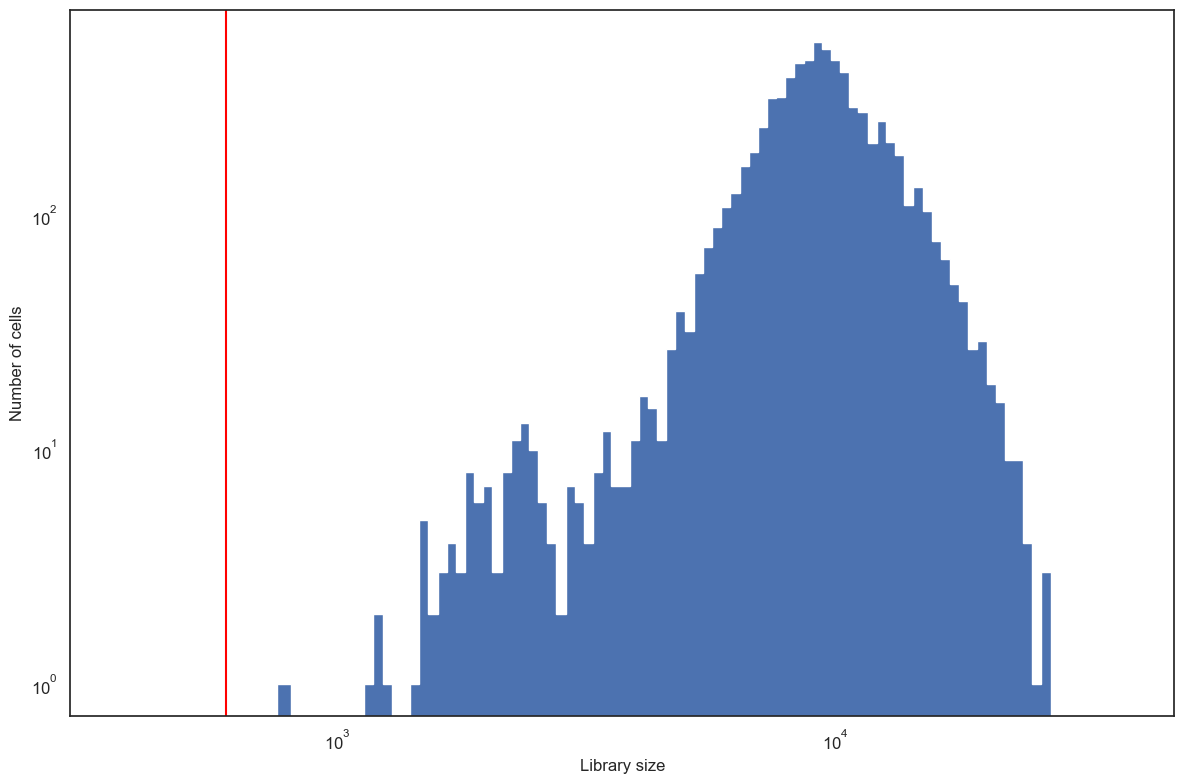

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [147]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [148]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [150]:
adata.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [151]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [152]:
%%time
emt_magic = magic_op.fit_transform(adata, genes=['Foxf2', 'Foxo1', 'Nos3'])

Calculating MAGIC...
  Running MAGIC on 7315 cells and 23341 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 12.53 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.55 seconds.
    Calculating affinities...
    Calculated affinities in 4.47 seconds.
  Calculated graph and diffusion operator in 21.63 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 21.85 seconds.
CPU times: total: 24.1 s
Wall time: 21.9 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [153]:
np.corrcoef(emt_magic[:,['Foxf2','Foxo1']].X, rowvar = False)[0][1]

0.5848404499977796

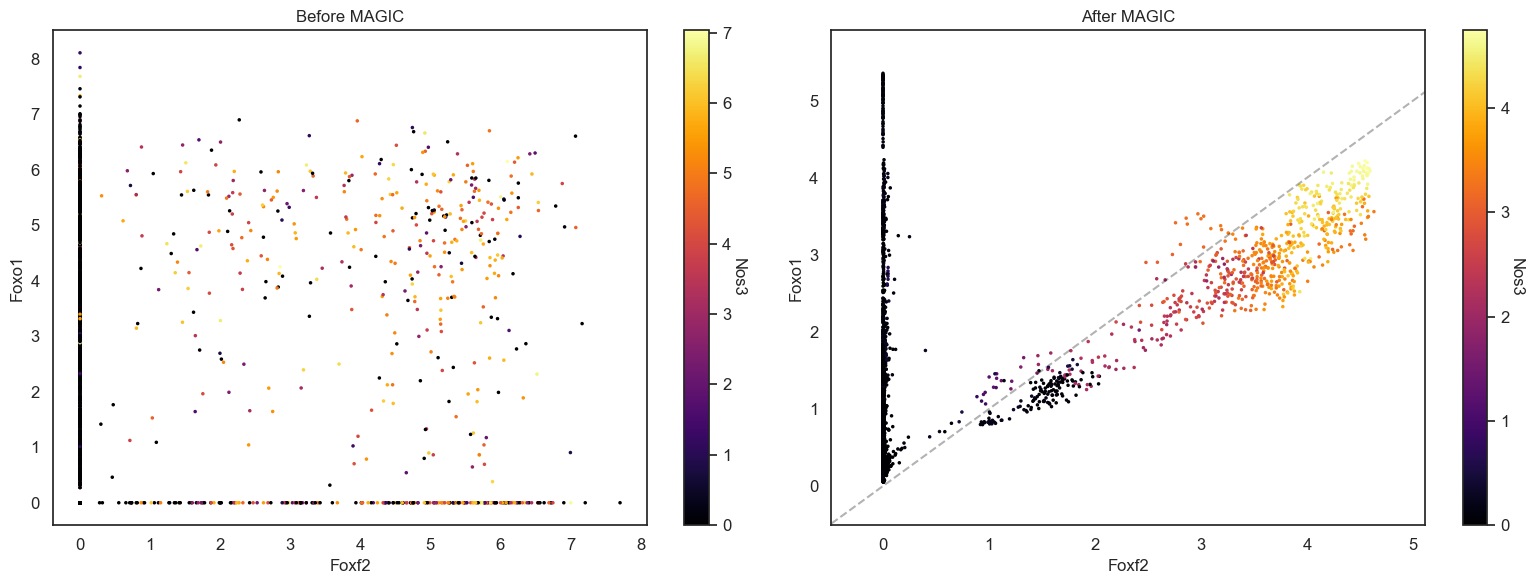

In [154]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata[:,'Foxf2'].X.todense(), y=adata[:,'Foxo1'].X.todense(), c=adata[:,'Nos3'].X.todense(), ax = ax1,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'Foxf2'].X, y=emt_magic[:,'Foxo1'].X, c=emt_magic[:,'Nos3'].X, ax=ax2,
                    xlabel='Foxf2', ylabel='Foxo1', legend_title="Nos3", title='After MAGIC')
plt.axline((1,1), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Session Info

In [156]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2